## Short-term and Long-term preference Integrated RECommender system. (SLi_Rec)

### SLi_Rec : Adaptive User Modeling with Long and Short-Term Preferences for Personailzed Recommendation
Unlike a general recommender such as Matrix Factorization or xDeepFM which doesn't consider the order of the user's activities, sequential recommender systems take the sequence of the user behaviors as context and the goal is to predict the items that the user will interact in a short time (in an extreme case, the item that the user will interact next).

SLi_Rec \[1\] is a deep learning-based model aims at capturing both long and short-term user preferences for precise recommender systems. To summarize, SLi_Rec has the following key properties:

* It adopts the attentive "Asymmetric-SVD" paradigm for long-term modeling;
* It takes both time irregularity and semantic irregularity into consideration by modifying the gating logic in LSTM.
* It uses an attention mechanism to dynamically fuse the long-term component and short-term component.

In this notebook, we test SLi_Rec on a subset of the public dataset: [Amazon_reviews] which includes all categories related to Electronics.

In [2]:
import sys
sys.path.append('/home/shiv/Documents/DataScience/Kaggle/recommenders/')

In [3]:
import sys
import os
import logging
import papermill as pm
import scrapbook as sb
from tempfile import TemporaryDirectory
import numpy as np
import tensorflow.compat.v1 as tf
tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.utils.timer import Timer
from recommenders.utils.constants import SEED
from recommenders.models.deeprec.deeprec_utils import (
    prepare_hparams
)

from recommenders.models.deeprec.models.sequential.sli_rec import SLI_RECModel as SeqModel
from recommenders.models.deeprec.io.sequential_iterator import SequentialIterator

print("System version: {}".format(sys.version))
print("Tensorflow version: {}".format(tf.__version__))


System version: 3.9.12 (main, Apr  5 2022, 06:56:58) 
[GCC 7.5.0]
Tensorflow version: 2.8.0


#### Parameters

In [3]:
EPOCHS = 10
BATCH_SIZE = 400
RANDOM_SEED = SEED  # Set None for non-deterministic result

DATA_DIR_WIDE_DEEP = '/home/shiv/Documents/DataScience/Capstone/Data/wide_deep/' # for top k predictions
yaml_file = '../../recommenders/models/deeprec/config/sli_rec.yaml'  
data_path = '/home/shiv/Documents/DataScience/Capstone/Data/slirec/Electronics'

### SLi-Rec
The SLi_Rec model is <b>time-aware</b>.

We use Softmax to the loss function. In training and evalution stage, we group 1 positive instance with `num_ngs` negative instances. Pair-wise ranking can be regarded as a special case of softmax ranking, where `num_ngs` is set to 1. 

More specifically, for training and evalation, we need to organize the data file such that each <b>one positive instance</b> is followed by <b>`num_ngs` negative instances</b>. 

The program will take `1+num_ngs` lines as a unit for Softmax calculation. `num_ngs` is a parameter you need to pass to the `prepare_hparams`, `fit` and `run_eval` function. `train_num_ngs` in `prepare_hparams` denotes the number of negative instances for training, where a recommended number is 4. `valid_num_ngs` and `num_ngs` in `fit` and `run_eval` denote the number in evalution. In evaluation, the model calculates metrics among the `1+num_ngs` instances. For the `predict` function, since we only need to calcuate a score for each individual instance, there is no need for `num_ngs` setting.

For training stage, we don't have to prepare negative instances, we can just provide positive instances and set the parameter `need_sample=True, train_num_ngs=train_num_ngs` for function `prepare_hparams`, our model will dynamicly sample `train_num_ngs` instances as negative samples in each mini batch.

###  Amazon dataset
Now let's start with a public dataset containing product reviews and metadata from Amazon, which is widely used as a benchmark dataset in recommemdation systems field.

In [4]:
user_vocab = os.path.join(data_path, r'user_vocab.pkl')
item_vocab = os.path.join(data_path, r'item_vocab.pkl')
cate_vocab = os.path.join(data_path, r'category_vocab.pkl')

In [5]:
train_file = os.path.join(data_path, r'train_data')
valid_file = os.path.join(data_path, r'valid_data')
test_file = os.path.join(data_path, r'test_data')

#### Prepare hyper-parameters
prepare_hparams() will create a full set of hyper-parameters for model training, such as learning rate, feature number, and dropout ratio. We can put those parameters in a yaml file (a complete list of parameters can be found under our config folder) , or pass parameters as the function's parameters (which will overwrite yaml settings).

Parameters hints: <br>
`need_sample` controls whether to perform dynamic negative sampling in mini-batch. 
`train_num_ngs` indicates how many negative instances followed by one positive instances.  <br>
Examples: <br>
(1) `need_sample=True and train_num_ngs=4`:  There are only positive instances in your training file. Our model will dynamically sample 4 negative instances for each positive instances in mini-batch. Note that if need_sample is set to True, train_num_ngs should be greater than zero. <br>
(2) `need_sample=False and train_num_ngs=4`: In your training file, each one positive line is followed by 4 negative lines. Note that if need_sample is set to False, you must provide a traiing file with negative instances, and train_num_ngs should match the number of negative number in your training file.

#### Hyperparameters
- learning_rate=0.001
- dropout=0.3
- item_embedding_dim=32
- cate_embedding_dim=8
- l2_norm=0
- batch_size=400
- train_num_ngs=4, valid_num_ngs=4, test_num_ngs=49

In [6]:
TRAIN_NUM_NEGS = 4
VALID_NUM_NEGS = 4
TEST_NUM_NEGS = 49
hparams = prepare_hparams(yaml_file, 
                          embed_l2=0., 
                          layer_l2=0., 
                          learning_rate=0.001,  # set to 0.01 if batch normalization is disable
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          show_step=1000,
                          MODEL_DIR=os.path.join(data_path, "model/"),
                          SUMMARIES_DIR=os.path.join(data_path, "summary/"),
                          user_vocab=user_vocab,
                          item_vocab=item_vocab,
                          cate_vocab=cate_vocab,
                          need_sample=True,
                          train_num_ngs=TRAIN_NUM_NEGS, # provides the number of negative instances for each positive instance for loss computation.
            )

In [7]:
hparams

HParams object with values {'use_entity': True, 'use_context': True, 'cross_activation': 'identity', 'user_dropout': True, 'dropout': [0.3, 0.3], 'attention_dropout': 0.0, 'load_saved_model': False, 'fast_CIN_d': 0, 'use_Linear_part': False, 'use_FM_part': False, 'use_CIN_part': False, 'use_DNN_part': False, 'init_method': 'tnormal', 'init_value': 0.01, 'embed_l2': 0.0, 'embed_l1': 0.0, 'layer_l2': 0.0, 'layer_l1': 0.0, 'cross_l2': 0.0, 'cross_l1': 0.0, 'reg_kg': 0.0, 'learning_rate': 0.001, 'lr_rs': 1, 'lr_kg': 0.5, 'kg_training_interval': 5, 'max_grad_norm': 2, 'is_clip_norm': 0, 'dtype': 32, 'optimizer': 'adam', 'epochs': 10, 'batch_size': 400, 'enable_BN': True, 'show_step': 1000, 'save_model': True, 'save_epoch': 1, 'write_tfevents': True, 'train_num_ngs': 4, 'need_sample': True, 'embedding_dropout': 0.0, 'EARLY_STOP': 10, 'min_seq_length': 1, 'slots': 5, 'cell': 'SUM', 'user_vocab': '/home/shiv/Documents/DataScience/Capstone/Data/slirec/Electronics/user_vocab.pkl', 'item_vocab': 

#### Create data loader
Designate a data iterator for the model. All our sequential models use SequentialIterator. 

Validation and testing data are files after negative sampling offline with the number of `<num_ngs>` and `<test_num_ngs>`.

In [8]:
input_creator = SequentialIterator

## [Jump to Model Serving](#model_serving) if we already have a pre-built model!

## Create model
When both hyper-parameters and data iterator are ready, we can create a model:

In [9]:
model = SeqModel(hparams, input_creator, seed=RANDOM_SEED)

## sometimes we don't want to train a model from scratch
## then we can load a pre-trained model like this: 
#model.load_model(r'your_model_path')

/home/shiv/Documents/DataScience/Kaggle/recommenders/recommenders/models/deeprec/models/base_model.py:701: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  curr_hidden_nn_layer = tf.compat.v1.layers.batch_normalization(
/home/shiv/anaconda3/envs/RecSys_39/lib/python3.9/site-packages/keras/legacy_tf_layers/normalization.py:463: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs, training=training)
2022-08-10 14:56:01.827427: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operatio

Now let's see what is the model's performance at this point (without starting training):

In [10]:
# test_num_ngs is the number of negative lines after each positive line in your test_file
print(model.run_eval(test_file, num_ngs=TEST_NUM_NEGS))

# {'auc': 0.5046, 'logloss': 0.6931, 'mean_mrr': 0.0943, 'ndcg@2': 0.0377, 'ndcg@4': 0.0571, 'ndcg@6': 0.0715, 'group_auc': 0.5048}

2022-08-10 15:02:31.150186: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


{'auc': 0.5046, 'logloss': 0.6931, 'mean_mrr': 0.0943, 'ndcg@2': 0.0377, 'ndcg@4': 0.0571, 'ndcg@6': 0.0715, 'group_auc': 0.5048}


AUC=0.5 is a state of random guess. We can see that before training, the model behaves like random guessing.

#### Train model
Next we want to train the model on a training set, and check the performance on a validation dataset.

In [11]:
with Timer() as train_time:
    model = model.fit(train_file, valid_file, valid_num_ngs=VALID_NUM_NEGS) 

# valid_num_ngs is the number of negative lines after each positive line in your valid_file 
# we will evaluate the performance of model on valid_file every epoch
print('Time cost for training is {0:.2f} mins'.format(train_time.interval/60.0))

step 1000 , total_loss: 1.3674, data_loss: 1.3674
step 2000 , total_loss: 1.2056, data_loss: 1.2056
step 3000 , total_loss: 1.1830, data_loss: 1.1830
step 4000 , total_loss: 1.0902, data_loss: 1.0902
step 5000 , total_loss: 1.1233, data_loss: 1.1233
step 6000 , total_loss: 1.1259, data_loss: 1.1259
step 7000 , total_loss: 1.0653, data_loss: 1.0653
step 8000 , total_loss: 1.0380, data_loss: 1.0380
eval valid at epoch 1: auc:0.7958,logloss:0.8247,mean_mrr:0.7191,ndcg@2:0.6818,ndcg@4:0.7772,ndcg@6:0.7898,group_auc:0.7917
step 1000 , total_loss: 0.9902, data_loss: 0.9902
step 2000 , total_loss: 0.9667, data_loss: 0.9667
step 3000 , total_loss: 0.9465, data_loss: 0.9465
step 4000 , total_loss: 0.9676, data_loss: 0.9676
step 5000 , total_loss: 0.8955, data_loss: 0.8955
step 6000 , total_loss: 0.9343, data_loss: 0.9343
step 7000 , total_loss: 0.8669, data_loss: 0.8669
step 8000 , total_loss: 0.9591, data_loss: 0.9591
eval valid at epoch 2: auc:0.8134,logloss:1.1699,mean_mrr:0.7403,ndcg@2:0.70

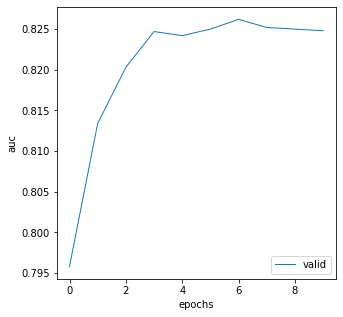

In [4]:
from recommenders.utils import plot

valid_auc = [0.7958, 0.8134, 0.8203, 0.8247, 0.8242, 0.825, 0.8262, 0.8252, 0.825, 0.8248]

x = range(1,11)
plot.line_graph(
    values=valid_auc,
    labels='valid',
    x_name='epochs',
    y_name='auc',
    legend_loc='lower right'
)

#### Evaluate model

Again, let's see what is the model's performance now (after training):

In [12]:
res_syn = model.run_eval(test_file, num_ngs=TEST_NUM_NEGS)
print(res_syn)

{'auc': 0.8225, 'logloss': 5.4335, 'mean_mrr': 0.3525, 'ndcg@2': 0.2748, 'ndcg@4': 0.3369, 'ndcg@6': 0.372, 'group_auc': 0.8232}


In [ ]:
sb.glue("res_syn", res_syn)

If we want to get the full prediction scores rather than evaluation metrics, we can do this:

In [15]:
# output_file = os.path.join(data_path, r'output.txt')
# model = model.predict(test_file, output_file)

<a id="model_serving"></a>
## Model Serving

In [9]:
model_best_trained = SeqModel(hparams, input_creator, seed=RANDOM_SEED)
path_best_trained = os.path.join(hparams.MODEL_DIR, "best_model")

print('loading saved model in {0}'.format(path_best_trained))
model_best_trained.load_model(path_best_trained)

/home/shiv/Documents/DataScience/Kaggle/recommenders/recommenders/models/deeprec/models/base_model.py:701: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  curr_hidden_nn_layer = tf.compat.v1.layers.batch_normalization(
/home/shiv/anaconda3/envs/RecSys_39/lib/python3.9/site-packages/keras/legacy_tf_layers/normalization.py:463: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs, training=training)
2022-08-10 20:35:57.005443: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operatio

loading saved model in /home/shiv/Documents/DataScience/Capstone/Data/slirec/Electronics/model/best_model


Let's see if we load the model correctly by running evaluation on a test file. The testing metrics should be better than what we had at the end of training where we did not load the best model. You can also [jump to predicting topK for a user](#topK).

In [10]:
 # Note: auc: 0.8242 as compared to 0.8225 from the model at the end of epoch 10
model_best_trained.run_eval(test_file, num_ngs=TEST_NUM_NEGS)

2022-08-10 20:42:41.645548: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


{'auc': 0.8242,
 'logloss': 3.9834,
 'mean_mrr': 0.352,
 'ndcg@2': 0.2738,
 'ndcg@4': 0.3361,
 'ndcg@6': 0.3714,
 'group_auc': 0.8238}

And we can make predictions using the best model. Then we can check if the metrics from run_eval match with those received from predict function which only outputs prediction scores.

In [11]:
output_file = os.path.join(data_path, r'output.txt')
model_best_trained.predict(test_file, output_file)

#### Check for consistent results

In [12]:
from sklearn.metrics import (roc_auc_score, log_loss)

# Gather the true labels
true_labels = []
with open(test_file, 'r') as f:
    for line in f:
        parts = line.split('\t')
        true_labels.append(float(parts[0]))
# Gather the predictions
preds = []
with open(output_file, 'r') as f:
    for line in f:
        preds.append(float(line))
print(roc_auc_score(true_labels, preds), log_loss(true_labels, preds))
# The ROC auc and logloss match!

0.8241692825299073 3.983422418807104


In [13]:
from recommenders.models.deeprec.deeprec_utils import cal_metric

# Pairwise metrics
group = TEST_NUM_NEGS + 1

group_labels = np.reshape(true_labels, (-1, group))
group_preds = np.reshape(preds, (-1, group))

cal_metric(group_labels, group_preds, ['mean_mrr', 'ndcg@2;4;6;10', 'group_auc'])
# And the pairwise metrics match too! We have ndcg@10 too!

{'mean_mrr': 0.352,
 'ndcg@2': 0.2738,
 'ndcg@4': 0.3361,
 'ndcg@6': 0.3714,
 'ndcg@10': 0.4128,
 'group_auc': 0.8238}

<a id="topK"></a>
### TopK prediction for a user

In [14]:
import _pickle as cPickle

with open(user_vocab, 'rb') as f:
    u_v = cPickle.load(f)test_
with open(item_vocab, 'rb') as f:
    v_v = cPickle.load(f)   

In [15]:
len(u_v), len(v_v) # only 497252 users in train (out of 830668), and 63715 items (out of 63725)

(497252, 63715)

In [16]:
import pandas as pd

# Get the userID who has the most reviews
prep_df = pd.read_csv(data_path + '/preprocessed.output', sep='\t', header=None)
prep_df.columns = ['type', 'label', 'userID', 'itemID', 'ts', 'category']
prep_df[['userID']].value_counts() # Note that we have 830668 users

userID        
ANGGNFE8DXGYC     324
ARBKYIVNYWK3C     243
A1H2WJSALF3E9U    238
A31N0XY2UTB25C    236
A1XXMNLOLKNO0I    232
                 ... 
A2WY5PH4O5CDW       1
A2WY5K9Z5KTF7M      1
A2WY50O1L0XMPD      1
A2WY4NSVFD6PO3      1
A1LCYW5S3IKKKM      1
Length: 830668, dtype: int64

In [22]:
prep_df['itemID'].nunique() # Note that we have 63725 items

63725

In [18]:
user = 'ANGGNFE8DXGYC'

u_df = prep_df[prep_df['userID']==user].copy()
u_df['ts'] = pd.to_datetime(u_df['ts'],unit='s')
u_df.sort_values(['ts'], inplace=True, ascending=False)
u_df

,type,label,userID,itemID,ts,category
72789,test,1,ANGGNFE8DXGYC,B013JZCAZK,2018-03-25,Computers
72788,valid,1,ANGGNFE8DXGYC,B00IXN6L3G,2018-03-25,All Electronics
72787,train,1,ANGGNFE8DXGYC,B00609B3J2,2018-03-25,Home Audio & Theater
72786,train,1,ANGGNFE8DXGYC,B00505EZYW,2018-03-25,All Electronics
72785,train,1,ANGGNFE8DXGYC,B000AO7SJW,2018-03-25,All Electronics
...,...,...,...,...,...,...
72497,train,1,ANGGNFE8DXGYC,B008ALA6DW,2015-06-26,Computers
72496,train,1,ANGGNFE8DXGYC,B0082ZJNW6,2015-06-26,Home Audio & Theater
72495,train,1,ANGGNFE8DXGYC,B007I59CN6,2015-06-26,Computers
72494,train,1,ANGGNFE8DXGYC,B006ZGCH18,2015-06-26,Computers


In [26]:
items_seen = u_df[u_df['type']!='test']['itemID'].unique()
print(len(items_seen))

all_items_set = set(prep_df['itemID'].unique())
items_not_seen = list(all_items_set - set(items_seen))

308


In [25]:
# Get the row from the test file for the user 'ANGGNFE8DXGYC'
test_df = pd.read_csv(test_file, sep='\t', header=None)
test_df.columns=['label', 'userID', 'itemID', 'category', 'ts', 'lst_items', 'lst_category', 'lst_ts']
test_df = test_df[test_df['userID'] == user]

In [27]:
from tqdm import tqdm

tmp_dir = TemporaryDirectory()

# we only need itemID->category
prep_df = prep_df[['itemID', 'category']]
prep_df.drop_duplicates(inplace=True)
prep_df.set_index('itemID', inplace=True)

In [34]:
# Create a test file with all the unseen items
tst_file = tmp_dir.name + '/tst_file'
out = open(tst_file, 'w')

# print(tst_file)
for item in tqdm(items_not_seen):
    if item.startswith('default'):
        continue
    lst = []
    lst.append('1')  # fake label: unused
    lst.append(user) # user
    lst.append(item) # unseen item
    lst.append(prep_df.loc[item]['category'])
    
    lst.append(str(test_df['ts'].values[0])) # timestamp and history remains the same as the first of 50 rows
    lst.append(test_df['lst_items'].values[0])
    lst.append(test_df['lst_category'].values[0])
    lst.append(test_df['lst_ts'].values[0])

    entry = '\t'.join(lst) + '\n'
    out.write(entry)

out.close()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 63417/63417 [00:02<00:00, 26087.22it/s]


In [35]:
# the model's predict function takes in an input test file and outputs prediction scores
output_file = os.path.join(tmp_dir.name, r'output.txt')
model_best_trained.predict(tst_file, output_file)

# now create a result dataframe along with scores
res_df = pd.read_csv(tst_file, sep='\t', header=None)
res_df.columns = ['label', 'userID', 'itemID', 'category', 'ts', 'lst_items', 'lst_cate', 'lst_ts']
res_df = res_df[['itemID', 'category']]
tmp_df = pd.read_csv(output_file, header=None)
tmp_df.columns = ['score']
res_df['score'] = tmp_df['score']

res_df.sort_values(['score'], ascending=False, inplace=True)
res_df.reset_index(inplace=True, drop=True)

In [53]:
items_df = pd.read_csv(DATA_DIR_WIDE_DEEP + 'all_meta_20.csv', header=None)
items_df.columns=['asin','price','title','main_cat','category']
items_df = items_df[['asin','title','category']]
items_df.sample(2)

,asin,title,category
215594,B001584R6E,Power Acoustik BAMF4000/1D 1200W Class D Mono ...,Electronics|Car & Vehicle Electronics|Marine E...
1231,B000BUBJ9A,Hanes Short Sleeve 6 oz Tagless T-Shirt with P...,"Clothing, Shoes & Jewelry|Men|Clothing|Shirts|..."


In [54]:
actual_item_clicked = test_df.iloc[0]['itemID']
items_df[items_df['asin'] == actual_item_clicked]

,asin,title,category
246366,B013JZCAZK,"New iPad 9.7"" (2018 & 2017) / iPad Pro 9.7 / i...",Electronics|Computers & Accessories|Tablet Acc...


In [56]:
res_merged = res_df.merge(items_df, left_on='itemID', right_on='asin')
res_merged.drop(columns=['itemID', 'asin'], inplace=True)
res_merged.iloc[:10]

,category_x,score,title,category_y
0,Computers,0.999899,Monoprice SlimRun Cat6A Ethernet Patch Cable -...,Electronics|Computers & Accessories|Computer A...
1,Computers,0.999894,"10Gtek for Cisco GLC-EX-SMD, Gigabit SFP EX Tr...",Electronics|Computers & Accessories|Networking...
2,Home Audio & Theater,0.999889,Edifier S1000DB Audiophile Active Bookshelf Sp...,Electronics|Home Audio|Speakers|Bookshelf Spea...
3,All Electronics,0.999886,AmazonBasics Component Video Cable with Audio ...,Electronics|Accessories & Supplies|Audio & Vid...
4,Computers,0.999886,Ubiquiti Unifi Security Gateway (USG),Electronics|Computers & Accessories|Networking...
5,Home Audio & Theater,0.999885,Cable Matters (5-Pack) Gold-Plated RG6 Keyston...,Electronics|Accessories & Supplies|Audio & Vid...
6,Home Audio & Theater,0.999881,"THE CIMPLE CO - Dual, Twin, or Siamese Coaxial...",Electronics|Accessories & Supplies|Cord Manage...
7,Computers,0.999866,Cable Matters 10-Pack Snagless Cat6 Ethernet C...,Electronics|Computers & Accessories|Computer A...
8,Computers,0.999864,UGREEN RJ45 Coupler 5 Pack In Line Coupler Cat...,Electronics|Computers & Accessories|Computer A...
9,Computers,0.999864,AmazonBasics RJ45 Cat7 Network Ethernet Patch ...,Electronics|Computers & Accessories|Computer A...


In [58]:
res_merged = res_df.merge(items_df, left_on='itemID', right_on='asin')
res_merged[res_merged['asin']=='B013JZCAZK']

,itemID,category_x,score,asin,title,category_y
2999,B013JZCAZK,Computers,0.998656,B013JZCAZK,"New iPad 9.7"" (2018 & 2017) / iPad Pro 9.7 / i...",Electronics|Computers & Accessories|Tablet Acc...


In [57]:
res_merged.drop(columns=['itemID', 'asin'], inplace=True)
res_merged.to_csv(data_path + '/output_8009.csv', index=False)

In [44]:
tmp_dir.cleanup()

## References
\[1\] Zeping Yu, Jianxun Lian, Ahmad Mahmoody, Gongshen Liu, Xing Xie. Adaptive User Modeling with Long and Short-Term Preferences for Personailzed Recommendation. In Proceedings of the 28th International Joint Conferences on Artificial Intelligence, IJCAI’19, Pages 4213-4219. AAAI Press, 2019.

\[2\] Balázs Hidasi, Alexandros Karatzoglou, Linas Baltrunas, Domonkos Tikk. Session-based Recommendations with Recurrent Neural Networks. ICLR (Poster) 2016

\[3\] Tang, Jiaxi, and Ke Wang. Personalized top-n sequential recommendation via convolutional sequence embedding. Proceedings of the Eleventh ACM International Conference on Web Search and Data Mining. ACM, 2018.

\[4\] Yuan, F., Karatzoglou, A., Arapakis, I., Jose, J. M., & He, X. A Simple Convolutional Generative Network for Next Item Recommendation. WSDM, 2019

\[5\] Lian, J., Batal, I., Liu, Z., Soni, A., Kang, E. Y., Wang, Y., & Xie, X. Multi-Interest-Aware User Modeling for Large-Scale Sequential Recommendations. (2021) arXiv preprint arXiv:2102.09211.